In [1]:
from planning import utils
from shapely import geometry
from trajectory_generator.vehicle_model_node import (
    TrajectoryGenerator,
    Vehicle,
)


In [2]:
vm = TrajectoryGenerator(
                         model=Vehicle(1),
                         step=0.1,
                         r=0.8,
                         r_step=1.0,
        )


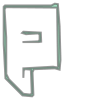

In [3]:
# no obstacle inflation
occ = utils.calculate_occupied_space('/home/itr/ItR/tutorials/src/driving_swarm_infrastructure/src/driving_swarm_bringup/maps/lndw2022.yaml', inflation=0)
occ

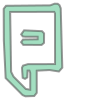

In [4]:
# with obstacle inflation
occ = utils.calculate_occupied_space('/home/itr/ItR/tutorials/src/driving_swarm_infrastructure/src/driving_swarm_bringup/maps/lndw2022.yaml')
occ

In [5]:
path = vm.tuples_to_path([(0.0, 0.0, 3.0), (1.0, 0.5, 3.1415)])
path

[(0.0, 0.0, 3.0),
 (-0.0785034569232921, 0.015227465160683904, 2.9000000000000004),
 (-0.15509451367683014, 0.03821612474542985, 2.8),
 (-0.22900789773917019, 0.06873628366670748, 2.7),
 (-0.29950509100927764, 0.10648299458519855, 2.5999999999999996),
 (-0.36588170883527144, 0.15107910484280934, 2.5),
 (-0.427474537993027, 0.20207902484735996, 2.4000000000000004),
 (-0.48366816329348233, 0.2589731802564969, 2.3),
 (-0.5339011166077783, 0.3211931034760797, 2.2),
 (-0.5776714868712052, 0.38811711360047035, 2.0999999999999996),
 (-0.6145419350126514, 0.4590765280426424, 2.0),
 (-0.6441440637020378, 0.5333623437895536, 1.9000000000000004),
 (-0.6661820982546623, 0.6102323215258866, 1.7999999999999998),
 (-0.680435841914081, 0.6889184018439366, 1.7000000000000002),
 (-0.6867628759853104, 0.7686343794393254, 1.5999999999999996),
 (-0.6850999828353497, 0.8485837586145188, 1.5),
 (-0.6754637775428742, 0.9279677116005494, 1.3999999999999995),
 (-0.6579505418858606, 1.0059930601800267, 1.2999999

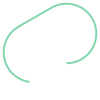

In [6]:
utils.path_2d(path)

In [7]:
occ.intersects(utils.path_2d(path))

True

In [8]:
occ.intersects(utils.path_2d(vm.tuples_to_path([(0.0,.0, .0), (10, 20, 0.0)])))

True

In [9]:
occ.intersects(geometry.Point(0.0, 0.0))

False

In [10]:
import networkx as nx

In [11]:
roadmap = nx.DiGraph()

In [12]:
roadmap.add_node((0.0, 0.0, 0.0))
roadmap.add_node((0.0, 1.0, 1.0))
roadmap.add_node((0.0, 1.5, 1.5))

In [13]:
path=vm.tuples_to_path([(0.0, 0.0, 0.0),(0.0, 1.0, 1.0)])
roadmap.add_edge((0.0, 0.0, 0.0), (0.0, 1.0, 1.0), path=path, cost=len(path))
path=vm.tuples_to_path([(0.0, 1.0, 1.0),(0.0, 1.5, 1.5)])
roadmap.add_edge((0.0, 1.0, 1.0), (0.0, 1.5, 1.5), path=path, cost=len(path))

In [14]:
s1 = nx.shortest_path(roadmap, (0.0, 0.0, 0.0), (0.0, 1.5, 1.5), weight="cost")
s1

[(0.0, 0.0, 0.0), (0.0, 1.0, 1.0), (0.0, 1.5, 1.5)]

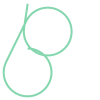

In [15]:
p1 = utils.path_2d(vm.tuples_to_path(s1))
p1

In [16]:
path=vm.tuples_to_path([(0.0, 0.0, 0.0),(0.0, 1.5, 1.5)])
roadmap.add_edge((0.0, 0.0, 0.0), (0.0, 1.5, 1.5), path=path, cost=len(path))
s2 = nx.shortest_path(roadmap, (0.0, 0.0, 0.0), (0.0, 1.5, 1.5), weight="cost")
s2

[(0.0, 0.0, 0.0), (0.0, 1.5, 1.5)]

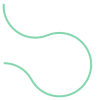

In [17]:
p2 = utils.path_2d(vm.tuples_to_path(s2))
p2

In [18]:
# plotting
import matplotlib.pyplot as plt
import shapely.ops as so
#from matplotlib.patches import Polygon
from descartes import PolygonPatch

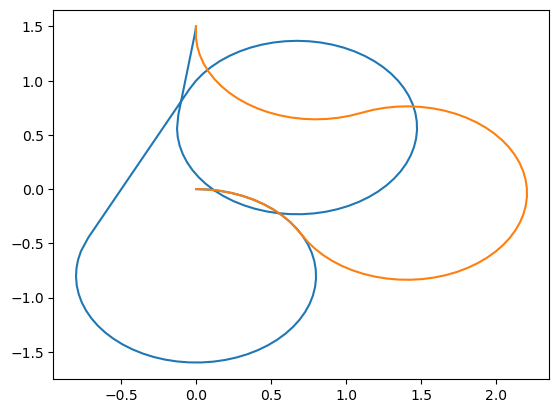

In [19]:
plt.figure()
for poly in so.unary_union(occ).geoms:#cascaded_union(occ):
    ax = plt.gca()
    #ax.add_patch(PolygonPatch(poly.buffer(0), alpha=0.2))
for path in [p1, p2]:
    plt.plot(*path.xy)
    
plt.show()

In [20]:
p1.intersects(occ)

True

In [21]:
p2.intersects(occ)

True

In [37]:
import numpy as np

def correct_path(path, occupied_space, num_iterations = 1000, step_size = 0.3):
    # check if path is colliding:
    if occupied_space.intersects(utils.path_2d(path)):
        start = [utils.path_2d(path).xy[0][0],utils.path_2d(path).xy[1][0]]
        goal = [utils.path_2d(path).xy[0][-1],utils.path_2d(path).xy[1][-1]]

        # Generate random points within the map space
        map_bounds = self.occupied_space.bounds
        x_min, y_min, x_max, y_max = map_bounds
        num_samples = 1000
        samples = []
        for _ in range(num_samples):
            x = np.random.uniform(x_min, x_max)
            y = np.random.uniform(y_min, y_max)
            samples.append((x, y))

        # Run the RRT algorithm to find a collision-free path
        rrt_path = utils.rrt_connect(start, goal, samples, self.occupied_space, self.vm)

        if rrt_path is None:
            self.get_logger().warn("RRT failed to find a path")
            return

        # Convert the RRT path to a trajectory path
        rrt_path = [path[0]] + rrt_path + [path[-1]]

        if rrt_path is None:
            print("RRT failed to find a path")
            return utils.path_2d(path)
        else: 
            # Convert the RRT path to a trajectory path
            return utils.path_2d(rrt_path)

In [38]:
p1 = correct_path(vm.tuples_to_path(s1),occ)
p2 = correct_path(vm.tuples_to_path(s2),occ)

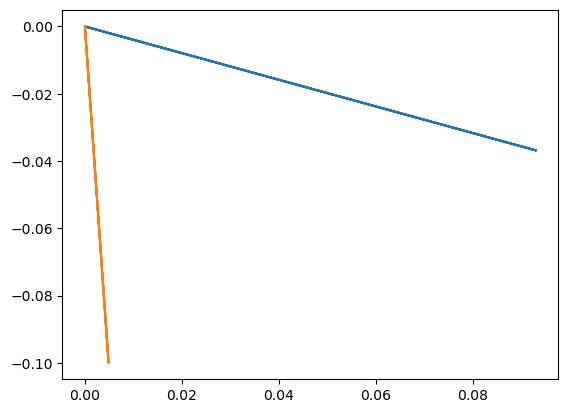

In [39]:
plt.figure()
for poly in so.unary_union(occ).geoms:#cascaded_union(occ):
    ax = plt.gca()
    #ax.add_patch(PolygonPatch(poly.buffer(0), alpha=0.2))
for path in [p1, p2]:
    plt.plot(*path.xy)
    
plt.show()

In [40]:
p1.intersects(occ)

False

In [41]:
p2.intersects(occ)

False